#### This analysis assumes a white noise spectrum

In [183]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import pandas as pd

#### Plotting paramerters

In [225]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 23,
          'axes.titlesize': 23,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize':5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### Fucntions for computing the correction factor due to the bunch length

In [120]:
def cmpt_bunch_length_correction_factor(sigma_phi, phase_noise = True):
    '''
    This function computes the correction factor, C, due to the bunch length, sigma_phi, assuming a 2D gaussian longitudinal distribution.
    - phase_noise = True (False): computes C for phase (amplitude) noise case
    - sigma_phi: in radians at the CC frequency
    
    - Io, I2l: Modified Bessel functions of the first kind. 
    - I2l: It converges to zero for larger orders. Therefore, a summation up to a large integer, here 10000 is used,  gives us trustworthy resutls.
    
    Note: Possibility to compute the factors for a pillbox distribution which is the other extreme (email from Themis). 
    '''

    if phase_noise:
        Io = iv(0, sigma_phi**2) # The first argument is the order
        I2l_sum = 0
        for order in range(2, 10000, 2):
            I2l_sum = I2l_sum + iv(order, sigma_phi**2)
         
        C = np.exp(-sigma_phi**2)*(Io+2*I2l_sum)
        
    else:
        I2ll_sum = 0
        for order in range(0, 10000, 2):
            I2ll_sum = I2ll_sum + iv(order+1, sigma_phi**2)
        
        C = np.exp(-sigma_phi**2)*I2ll_sum
        
    return C

In [124]:
def emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, PSD_phi):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaPhi*PSD_phi
    return 2*ey_rate # the factor of 2 corresponds to the number of betatron sidebands we "see"

In [125]:
def emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaA*PSD_A
    return 4*ey_rate # the factor of 4 corresponds to the number of betatron and synchrobetatron sidebands we "see"

In [128]:
def bunch_length_m_to_rad(L, clight, f_RF):
    phi = L*(2*np.pi*f_RF)/clight
    return phi

#### 1) Load the data
a) Load from /afs/ or from .csv file

b) Load the values of the transverse emittance in a dictionary.

In [129]:
n_runs = 3 # number of runs that the simulation was repeated
turns = 1e5
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 
clight = 299792458

In [4]:
z_list = np.linspace(0, 0.19, 15)

In [203]:
type_of_noise = 'AN'
path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/tbt_from_GPUs/bunch_length_dependence/{}/'.format(type_of_noise)

In [205]:
ex_dict = {} # type: dictionary
ey_dict = {}

for index, z in enumerate(z_list[1:]):
    print(index, z)
    for run in range(n_runs):
        temp_name = 'z{:.2f}_run{}'.format(z, run) # the suffix of the name of the current study
        # A. load the turn by turn data in a dictionary
        temp_dict = pickle.load( open( path_to_data+'tbt_sigmaZ{}_run{}.pkl'.format(index, run), "rb" ) )
        # B. Create a different list for each run and save the emittance values
        ex_dict[temp_name] = temp_dict['neps_x'] # PΝ
        ey_dict[temp_name] = temp_dict['neps_y']

In [206]:
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list

#### 3) Perform the linear fit for each one of the runs for each set of parameters

In [207]:
m_dict = {}
b_dict = {}
err_dict = {}

for run in range(n_runs):
    for z in z_list[1:]:
        
        temp_name = 'z{:.2f}_run{}'.format(z, run) # the suffix of the name of the current study
        [m, b], cov = np.polyfit(time, ey_dict[temp_name], 1, cov=True)
        err= np.sqrt(np.diag(cov))
            
        m_dict[temp_name] = m
        b_dict[temp_name] = b
        err_dict[temp_name] = err

#### 4) Compute the mean and the std of the growth rates for each set of ayy and rms_ksi.

In [208]:
dey_mean = []
dey_std = []

for z in z_list[1:]:
    m_list = []
    for run in range(n_runs):
        temp_name = 'z{:.2f}_run{}'.format(z, run)
        m_list.append(m_dict[temp_name])
    dey_mean.append(np.mean(m_list))
    dey_std.append(np.std(m_list))

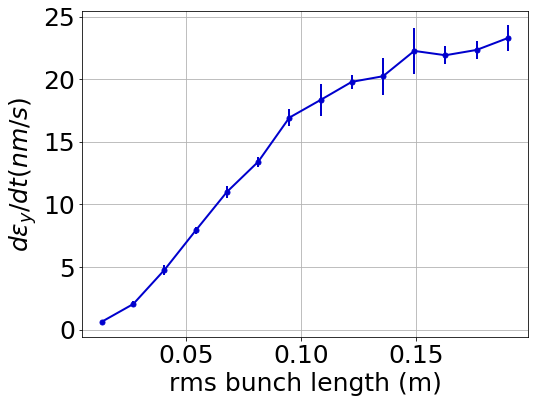

In [209]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.errorbar(z_list[1:], np.array(dey_mean)*1e9,yerr= np.array(dey_std)*1e9, marker ='o', color ='mediumblue', label='simulations')#, label=r'$rms(\xi)  / 2 \pi = {} $'.format(rms_ksi))
ax1.set_ylabel(r'$d\epsilon_y /dt (nm/s)$')
ax1.set_xlabel('rms bunch length (m)')
ax1.grid()

#### 5) Compare with the theoretical expectations

For a 2D Gaussian longitudinal distribution

### SPS parameters

In [210]:
betay = 76 # m
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
A = 1e-8 # rms kick in the simulation
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
PSD_phi = (A*scale_factor)**2/frev
beta_0 = 0.999999
gamma_0 = 287.7

In [222]:
dey_list = []
z_list_long = np.linspace(0, 0.19, 15) # more points for a nice curve of the theoretical estimation
for z in z_list_long[1:]:
    
    sigma_phi = bunch_length_m_to_rad(z, clight, 400.789e6)
    C = cmpt_bunch_length_correction_factor(sigma_phi, False)
    
    dey = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, C, PSD_phi)
    dey_list.append(dey*beta_0*gamma_0)

In [223]:
# sigma_phi at SPS CC tests
sigma_z = 0.155 # m
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, 400.789e6)
print(sigma_phi)
C = cmpt_bunch_length_correction_factor(sigma_phi, False)
print(C)
dey_SPS_tests = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, C, PSD_phi)*beta_0*gamma_0*1e9
print(dey_SPS_tests)

1.3019870272796386
0.24157569921889774
22.95070580111898


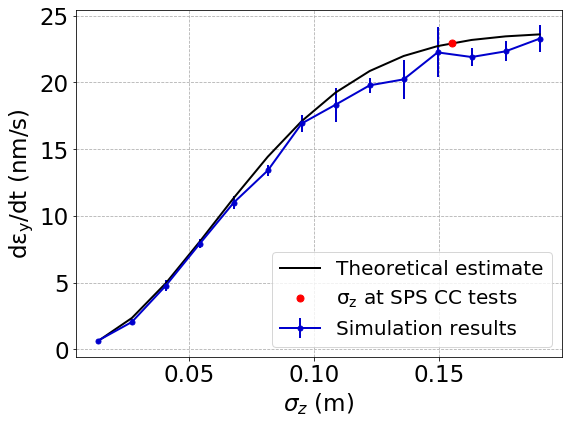

In [227]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.errorbar(z_list[1:], np.array(dey_mean)*1e9,yerr= np.array(dey_std)*1e9, marker ='o', color ='mediumblue', label='Simulation results')#, label=r'$rms(\xi)  / 2 \pi = {} $'.format(rms_ksi))
ax1.plot(z_list_long[1:], np.array(dey_list)*1e9, c='k', label='Theoretical estimate')
ax1.plot(sigma_z, dey_SPS_tests, 'o',color='r', markersize=7, label=r'$\rm \sigma_z$' +' at SPS CC tests')
ax1.set_ylabel(r'$\rm d\epsilon_y /dt$' + ' (nm/s)')
ax1.set_xlabel(r'$\sigma_z $'+' (m)')
ax1.grid(linestyle='--')
ax1.legend()
plt.tight_layout()
plt.savefig('dey_vs_BunchLength_AmplitudeNoise.png')

### Option to save the computed growth rates along with the error

In [211]:
save_data = False
if save_data:
    data = {'sigma_z (m)': z_list[1:], 'dey/dt (m/s)': dey_mean, 'std (m/s)': dey_std}
    df = pd.DataFrame(data)
    
    df.to_csv('dey_std_vs_sigma_z_amplitude_noise.csv')